In [1]:
%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Digit Recognizer using Convolutional Neural Nets
Starting with a brief benchmark below, which was [found in the forums](https://www.kaggle.com/c/digit-recognizer/forums/t/2299/getting-started-python-sample-code-random-forest) we can use this to solve the digit recognizer problem with 0.96 accuracy score in less than a minute of learning. However, a neural net would have better accuracy.

In [2]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

# create the training & test sets, skipping the header row with [1:]
dataset = pd.read_csv("../data/train.csv")
target = dataset[[0]].values.ravel()
train = dataset.iloc[:,1:].values
test = pd.read_csv("../data/test.csv").values

# create and train the random forest
# multi-core CPUs can use: rf = RandomForestClassifier(n_estimators=100, n_jobs=2)
#rf = RandomForestClassifier(n_estimators=100)
#rf.fit(train, target)
#pred = rf.predict(test)

#np.savetxt('submission_rand_forest.csv', np.c_[range(1,len(test)+1),pred], delimiter=',', header = 'ImageId,Label', comments = '', fmt='%d')

## Lets take a look at the data.
train.csv has 42k rows. THe first column is the digit label and the rest 784 columns are 8 bit 256 pixel color values ranging from 0 to 255.

The test.csv contains only the pixel color values which we need to classify as digits. lets see what we're working with here

In [3]:
dataset.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Convert each data variable from a python list into a numpy array. For the target array I specify the integer data type. The train set has 42k rows and 784 columns, so its shape is (42k,784). Each row is a 28 by 28 pixel picture. I will reshape the train set to have (42k,1) shape, i.e. each row will contain a 28 by 28 matrix of pixel color values. Same for the test set.

In [8]:
# convert to array, specify data type, and reshape
target = target.astype(np.uint8)
train = np.array(train).reshape(-1,1, 28, 28) # -1 means the value is inferred from the original array 42k in this case
test = np.array(test).reshape((-1, 1, 28, 28)).astype(np.uint8)

Now, we can actually plot those pixel color values and see what a sample picture of a digit looks like. Below is the picture of a digit in the 1700th row:

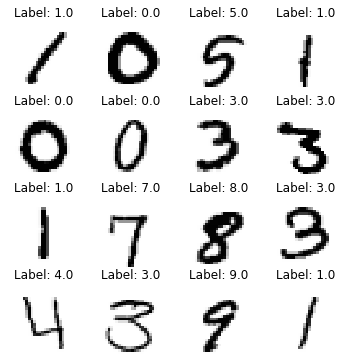

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

figs, axes = plt.subplots(4, 4, figsize=(6, 6))
for i in range(4):
    for j in range(4):
        axes[i, j].imshow(-train[i + 4 * j].reshape(28, 28), cmap='gray', interpolation='none')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].set_title("Label: {}".format(target[i + 4 * j]))
        axes[i, j].axis('off')
        
# plt.imshow(train[1700][0], cmap=cm.binary) # draw the picture

# Train, Predict and Save
Below is a simple NN set up. Supposedly, it should give >0.9 accuracy score. I had trouble with figuring out the training part in that the accuracy I was getting would not change during the training process. All I had to do was to decrease the learning rate from 0.01 to 0.0001, nota bene.

In [10]:
import lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import visualize

net1 = NeuralNet(
        layers = [
            # layer dealing with the input data
            (InputLayer, {'shape': (None, X.shape[1], X.shape[2], X.shape[3])}),

            # first stage of our convolutional layers
            (Conv2DLayer, {'num_filters': 96, 'filter_size': 5}),
            (Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
            (Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
            (Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
            (Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
            (MaxPool2DLayer, {'pool_size': 2}),

            # second stage of our convolutional layers
            (Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
            (Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
            (Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
            (MaxPool2DLayer, {'pool_size': 2}),

            # two dense layers with dropout
            (DenseLayer, {'num_units': 64}),
            (DropoutLayer, {}),
            (DenseLayer, {'num_units': 64}),

            # the output layer
            (DenseLayer, {'num_units': 10, 'nonlinearity': softmax}),
        ],
        # layer parameters:
        input_shape=(None,1,28,28),
        hidden_num_units=1000, # number of units in 'hidden' layer
        output_nonlinearity=lasagne.nonlinearities.softmax,
        output_num_units=10,  # 10 target values for the digits 0, 1, 2, ..., 9

        # optimization method:
        update=nesterov_momentum,
        update_learning_rate=0.0001,
        update_momentum=0.9,
        max_epochs=15,
        verbose=1,
        )

In [11]:
# Train the network
net1.fit(train, target)

# Neural Network with 795010 learnable parameters

## Layer information

  #  name    size
---  ------  -------
  0  input   1x28x28
  1  hidden  1000
  2  output  10



TypeError: ('Bad input argument to theano function with name "//anaconda/lib/python2.7/site-packages/nolearn/lasagne/base.py:504"  at index 1(0-based)', 'TensorType(int32, vector) cannot store a value of dtype float32 without risking loss of precision. If you do not mind this loss, you can: 1) explicitly cast your data to int32, or 2) set "allow_input_downcast=True" when calling "function".', array([ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  0.,  0.,  6.,  2.,  2.,  0.,  2.,  6.,  6.,
        0.,  6.,  2.,  9.,  6.,  6.,  0.,  6.,  6.,  6.,  6.,  0.,  6.,
        0.,  9.,  4.,  4.,  2.,  2.,  0.,  9.,  2.,  4.,  4.,  4.,  6.,
        4.,  6.,  4.,  2.,  9.,  2.,  5.,  9.,  6.,  5.,  5.,  2.,  5.,
        2.,  9.,  2.,  2.,  0.,  0.,  6.,  0.,  9.,  2.,  0.,  6.,  2.,
        5.,  0.,  5.,  2.,  9.,  9.,  0.,  0.,  9.,  0.,  5.,  0.,  5.,
        5.,  6.,  4.,  4.,  0.,  5.,  4.,  9.,  6.,  2.,  4.], dtype=float32))